##### Tải lên thư viện cần thiết

In [387]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# Import to ignore warnings
import warnings
warnings.filterwarnings("ignore")

##### Tải lên dữ liệu

In [389]:
# Đổi đuôi file csv để làm việc với mã cỗ phiếu tương ứng
# Example: Change to 'VIC.csv' to work with VIC dataset
url = 'https://raw.githubusercontent.com/tmy-611/dataset/refs/heads/main/Stock/MSN.csv'
data = pd.read_csv(url)
data.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,MSN,12/25/2017 9:15,73.1,73.1,73.1,73.1,4210,0
1,MSN,12/25/2017 9:16,73.0,73.0,73.0,73.0,5000,0
2,MSN,12/25/2017 9:18,73.5,73.5,73.5,73.5,210,0
3,MSN,12/25/2017 9:20,73.2,73.5,73.1,73.1,2050,0
4,MSN,12/25/2017 9:21,73.0,73.0,73.0,73.0,1380,0


In [390]:
# Kiểm tra datatype của từng cột
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135354 non-null  object 
 1   Date/Time      135354 non-null  object 
 2   Open           135354 non-null  float64
 3   High           135354 non-null  float64
 4   Low            135354 non-null  float64
 5   Close          135354 non-null  float64
 6   Volume         135354 non-null  int64  
 7   Open Interest  135354 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 8.3+ MB


In [391]:
# Kiểm tra cột constant
data.nunique()

,0
Ticker,1
Date/Time,135354
Open,1110
High,1094
Low,1112
Close,1111
Volume,5316
Open Interest,1


##### Xử lý dữ liệu

In [392]:
# Đổi tên cột
data.columns = ['ticker', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'open_interest']

# Loại bỏ cột có giá trị constant (nunique = 1)
data = data.drop(columns=['open_interest', 'ticker'])

# Chuyển cột datetime sang dạng datetime
data['datetime'] = pd.to_datetime(data['datetime'])
data.head()

,datetime,open,high,low,close,volume
0,2017-12-25 09:15:00,73.1,73.1,73.1,73.1,4210
1,2017-12-25 09:16:00,73.0,73.0,73.0,73.0,5000
2,2017-12-25 09:18:00,73.5,73.5,73.5,73.5,210
3,2017-12-25 09:20:00,73.2,73.5,73.1,73.1,2050
4,2017-12-25 09:21:00,73.0,73.0,73.0,73.0,1380


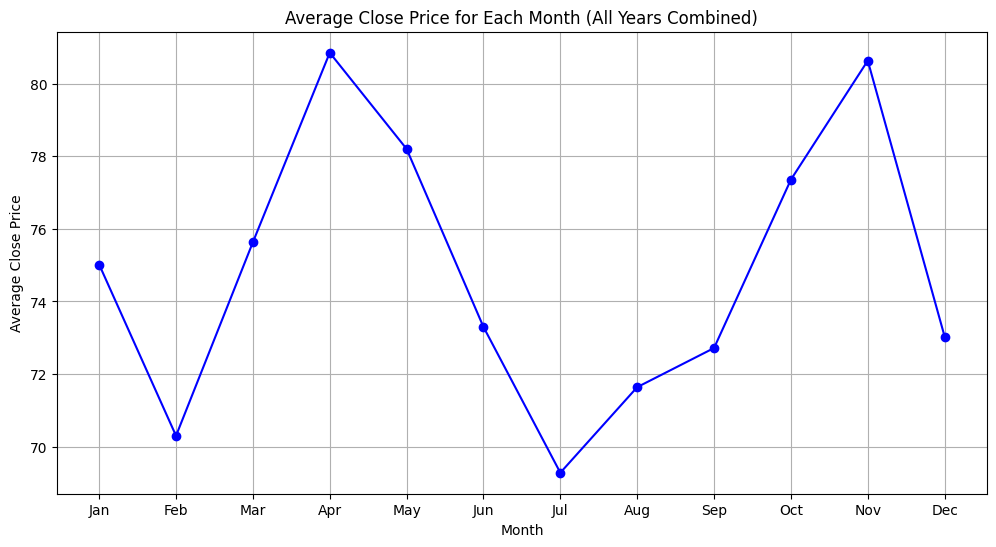

In [393]:
# Tạo cột 'month' để nhóm dữ liệu theo từng tháng
data['month'] = data['datetime'].dt.month

# Gộp dữ liệu theo tháng và lấy trung bình
monthly_avg = data.groupby('month')['close'].mean().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg['month'], monthly_avg['close'], color='blue', marker='o', linestyle='-')

plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.title('Average Close Price for Each Month (All Years Combined)')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Hiển thị tháng dạng chữ
plt.grid(True)
plt.show()


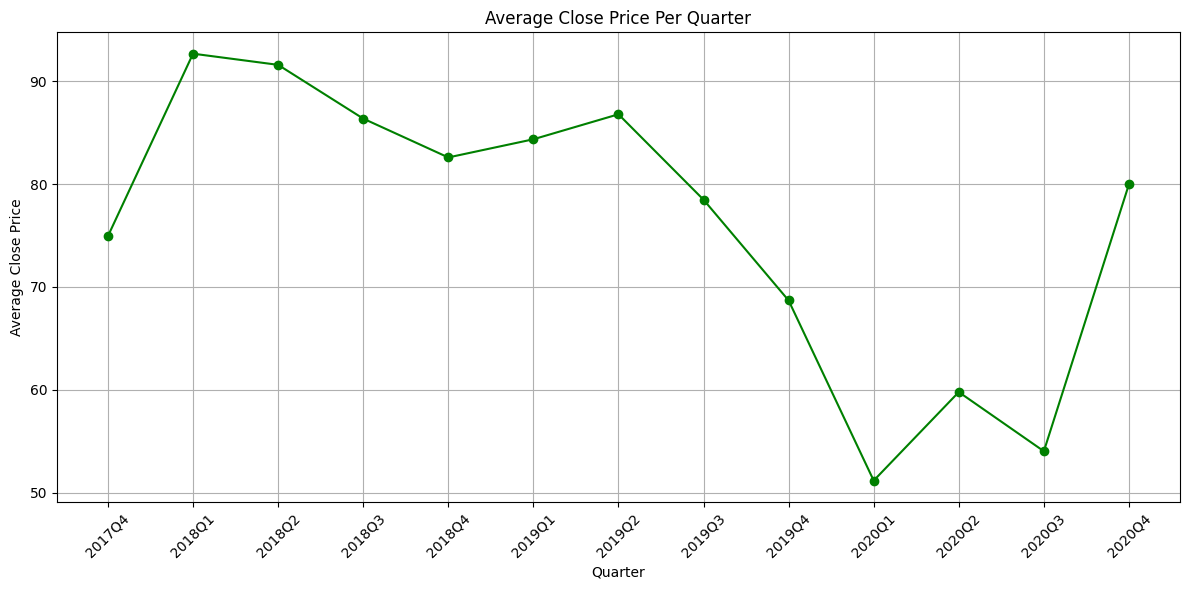

In [394]:
# Tạo cột quý (YYYY-QX)
data['quarter'] = data['datetime'].dt.to_period('Q')

# Gộp dữ liệu theo quý và lấy trung bình
quarterly_data = data.groupby('quarter')['close'].mean().reset_index()
quarterly_data['quarter'] = quarterly_data['quarter'].astype(str)  # Chuyển về chuỗi để vẽ

plt.figure(figsize=(12, 6))
plt.plot(quarterly_data['quarter'], quarterly_data['close'], color='green', marker='o', linestyle='-')

plt.xlabel('Quarter')
plt.ylabel('Average Close Price')
plt.title('Average Close Price Per Quarter')
plt.xticks(rotation=45)  # Xoay nhãn trục x để dễ đọc
plt.grid(True)
plt.tight_layout()
plt.show()


In [395]:
# Chuyển datetime thành ngày (bỏ phần giờ phút)
data['date'] = data['datetime'].dt.date

# Gộp dữ liệu theo ngày
data = data.groupby('date').agg({
    'open': 'first',    # Giá mở cửa là giá đầu tiên trong ngày
    'high': 'max',      # Giá cao nhất trong ngày
    'low': 'min',       # Giá thấp nhất trong ngày
    'close': 'last',    # Giá đóng cửa là giá cuối cùng trong ngày
    'volume': 'sum'     # Tổng khối lượng giao dịch trong ngày
}).reset_index()

# Hiển thị kết quả
print(data.head())

         date  open  high   low  close  volume
0  2017-12-25  73.1  75.4  73.0   74.2  207370
1  2017-12-26  74.9  75.5  74.3   75.5  403710
2  2017-12-27  74.9  75.7  74.8   75.0  517920
3  2017-12-28  75.0  76.0  74.5   75.7  377030
4  2017-12-29  76.0  77.0  76.0   76.7  226880


In [396]:
# Tạo một dataframe mới để dễ huấn luyện mô hình hơn
df = pd.DataFrame(data,columns=['date', 'close'])
df.index = df.date
df.drop('date', axis=1, inplace=True)
df.head()

,close
date,
2017-12-25,74.2
2017-12-26,75.5
2017-12-27,75.0
2017-12-28,75.7
2017-12-29,76.7


In [397]:
# Xác định kích thước train
train_size = int(len(data) * 0.8)

# Trích xuất giá trị của dataframe (giá trị Close)
values = df.values

# Chia tệp train và test
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [398]:
# Chuẩn hoá dữ liệu về phạm vi 0 tới 1
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(values)

In [399]:
# Tạo vòng lặp giá trị cho mô hình dự đoán biến động giá sau 30 ngày
x_train,y_train=[],[]
for i in range(30,len(train)):
  x_train.append(sc_train[i-30:i,0]) #lấy 30 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [400]:
# Xếp dữ liệu thành numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)

# Xếp lại dữ liệu thành mảng 3D
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

##### 3. Xây dựng và huấn luyện mô hình

In [401]:
# Xây dựng mô hình
model = Sequential()

# 2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(1))

# Đo sai số tuyệt đối trung bình
model.compile(loss='mean_absolute_error',optimizer='adam')

In [402]:
#  Cài đặt vị trí lưu model tốt nhất
save_model = "best_model.keras"

# Quyết định model nào là tốt nhất nhờ hàm loss
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')

# Huấn luyện mô hình
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.19329, saving model to best_model.keras
12/12 - 6s - 503ms/step - loss: 0.1933
Epoch 2/100

Epoch 2: loss improved from 0.19329 to 0.09432, saving model to best_model.keras
12/12 - 1s - 69ms/step - loss: 0.0943
Epoch 3/100

Epoch 3: loss improved from 0.09432 to 0.07813, saving model to best_model.keras
12/12 - 1s - 72ms/step - loss: 0.0781
Epoch 4/100

Epoch 4: loss improved from 0.07813 to 0.07130, saving model to best_model.keras
12/12 - 1s - 68ms/step - loss: 0.0713
Epoch 5/100

Epoch 5: loss improved from 0.07130 to 0.06926, saving model to best_model.keras
12/12 - 1s - 112ms/step - loss: 0.0693
Epoch 6/100

Epoch 6: loss improved from 0.06926 to 0.06653, saving model to best_model.keras
12/12 - 1s - 71ms/step - loss: 0.0665
Epoch 7/100

Epoch 7: loss did not improve from 0.06653
12/12 - 1s - 68ms/step - loss: 0.0675
Epoch 8/100

Epoch 8: loss improved from 0.06653 to 0.06493, saving model to best_model.keras
12/12 - 1s - 72ms/step

In [403]:
# Huấn luyện dự đoán dựa trên tập train
# Chuyển giá trị đã được chuẩn hoá về lại giá trị thực
y_train = sc.inverse_transform(y_train)

# Tải lên model tốt nhất đã được lưu trước đó lên để dự đoán
final_model = load_model("best_model.keras")

# Dự đoán giá close trên tập train (giá đã được chuẩn hoá)
y_train_predict = final_model.predict(x_train)
# --> Chuyển về giá thực
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [404]:
# Xử lý dữ liệu tập test
test = df[len(train)-30:].values # Trích xuất giá trị
test = test.reshape(-1,1)
sc_test = sc.transform(test) # Chuẩn hoá

# Vòng lặp giá trị cho huấn luyện mô hình dự đoán biến động giá sau 30 ngày
x_test = []
for i in range(30,test.shape[0]):
  x_test.append(sc_test[i-30:i,0])

# Reshape dữ liệu
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

# Dữ liệu test
y_test = values[train_size:] # Giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #Giá dự đoán

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


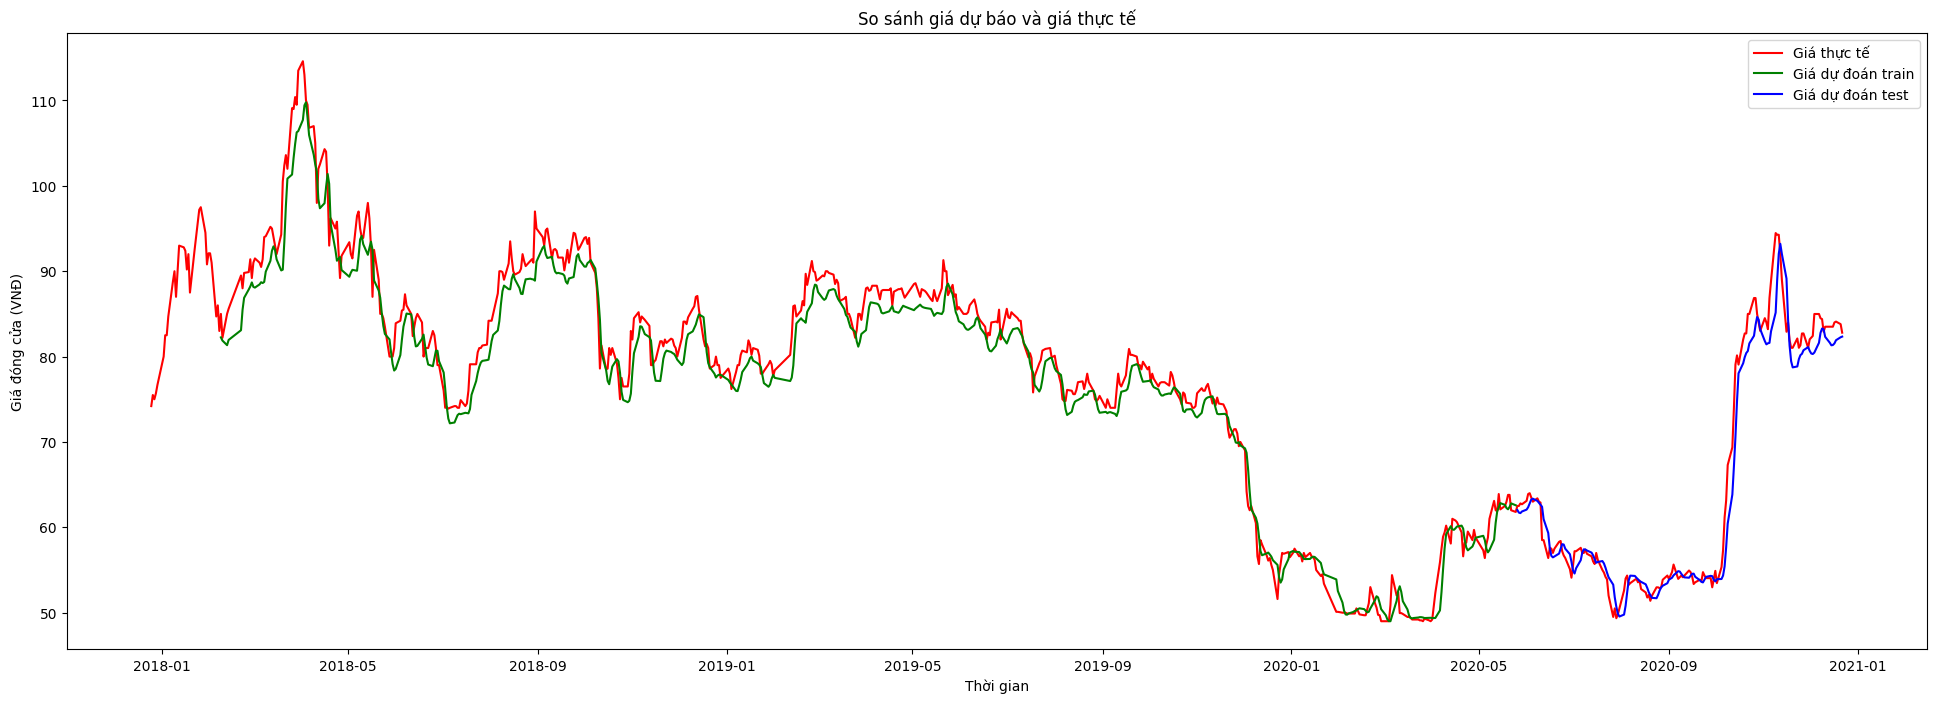

In [405]:
# Lập biểu đồ so sánh Gía thực tế và Gía dự đoán
train_data1 = df[30:train_size]
test_data1 = df[train_size:]

plt.figure(figsize=(24,8))
plt.plot(df,label='Giá thực tế',color='red')
train_data1['Dự đoán'] = y_train_predict
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green')
test_data1['Dự đoán'] = y_test_predict
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()


##### Kết quả huấn luyện mô hình

In [406]:
print('R2 Score on Train:',r2_score(y_train,y_train_predict))
print('Mean Absolute Error on Train:',mean_absolute_error(y_train,y_train_predict))
print('Mean Absolute Percentage Error on Train:',mean_absolute_percentage_error(y_train,y_train_predict))


R2 Score on Train: 0.9680647362039221
Mean Absolute Error on Train: 1.942639043297566
Mean Absolute Percentage Error on Train: 0.02409287799571475


In [407]:
print('R2 Score on Test:',r2_score(y_test,y_test_predict))
print('Mean Absolute Error on Test:',mean_absolute_error(y_test,y_test_predict))
print('Mean Absolute Percentage Error on Test:',mean_absolute_percentage_error(y_test,y_test_predict))


R2 Score on Test: 0.9695166429945634
Mean Absolute Error on Test: 1.6616554687499996
Mean Absolute Percentage Error on Test: 0.023942720592951005


##### Tải mô hình về máy

In [408]:
from google.colab import files
files.download("best_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>